In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import re
import seaborn as sns
%matplotlib inline

In [33]:
df = pd.read_csv("results.csv")
df['gpus'] = df['gpus_per_node'] * df['nodes']
df.sort_values(by='gpus')
df

,nodes,gpus_per_node,model,local_batch_size,samples_per_sec,secs_per_batch,gpus
0,1,1,ViT-B-32,256,488.437686,0.524120,1
1,1,6,ViT-B-32,256,2946.031038,0.521379,6
2,2,6,ViT-B-32,256,5831.096280,0.526831,12
3,4,6,ViT-B-32,256,11383.341437,0.539736,24
4,8,6,ViT-B-32,256,22478.201769,0.546663,48
5,16,6,ViT-B-32,256,43421.459354,0.565987,96
6,32,6,ViT-B-32,256,76460.063815,0.642845,192
7,64,6,ViT-B-32,256,133197.269889,0.738033,384
8,128,6,ViT-B-32,256,170397.386107,1.153821,768


In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_scaling_and_efficiency(df, **kw):
    """
    Render scaling and efficiency plots

    - Scaling plot is the relationship between the number of GPUs used
      and the speedup in the throughput
    - Efficiency is the ratio of throughput to ideal reference throughput
    """
    df = df.copy()
    # Number of GPUs per run
    df["GPUs"] = df["gpus"]
    df = df.sort_values(by="GPUs")

    # reference number of GPUs is the run with minimal number of GPUs
    refrence_nb_gpus = df.iloc[0]['GPUs']
    # reference throughput is the throughput of the configuration with the reference number of GPUs
    reference_secs = df.iloc[0]["secs_per_batch"]
    df["Speedup"] = (reference_secs / df['secs_per_batch']) * df['gpus']
    # efficiency is the  $E(K) = 100 \times \frac{T(K)}{K \times T(1)}$, where:
    # - $K$ is the number of GPUs
    # - $T(K)$ is the throughput for $K$ GPUs
    # - $T(1)$ the reference throughput (for $K=1$)
    df['efficiency'] =  reference_secs/ df["secs_per_batch"]
    scale = df.Speedup.max() * 1.5
    top = 0
    text_spacing = 0.4

    min_node = 2
    df = df[df.nodes>=min_node]
    cs = clip_scaling[clip_scaling.nodes>=min_node]

    # plot
    fig, ax1 = plt.subplots(**kw)
    plt.xticks(fontsize=18) 
    plt.yticks(fontsize=22) 

    y = df['efficiency'] * 100#* scale + top

    ax1.set_ylabel('Efficiency (%)', color='red', fontsize=22)
    ax1.plot(df.GPUs, y, c='red', marker="o", label='efficiency')
    #ax1.plot(cs.gpus, cs.Efficiency, c='green', marker="o", label='efficiency')

    ax1.tick_params(axis='y', labelcolor='red')
    ax1.set_xlabel('GPUs', fontsize=15)
    
    for nb_gpus, effval, yval in zip(df.GPUs, df['efficiency'], y):
        ax1.text(nb_gpus, yval+text_spacing, f"{effval*100:.2f}%", size=16, c='red')
        
        
    ax2 = ax1.twinx()
    plt.xticks(fontsize=18) 
    plt.yticks(fontsize=22) 

    ax2.plot(df.GPUs, df.Speedup, 'go--', label='Speedup (ViT-B/32)', color='blue')
    #ax2.plot(cs.gpus, cs.Speedup, 'go--', label='Speedup (CLIP ViT-B/32)', color='green')

    ax2.set_xlabel('GPUs')
    ax2.set_ylabel('Speedup',color='blue', fontsize=22)
    ax2.set_xticks(df.GPUs)
    ax2.plot(df.GPUs, df.GPUs / refrence_nb_gpus, 'go-', label='Ideal speedup', color='orange')

    ax2.tick_params(axis='y', labelcolor='blue')
    plt.xlabel("Number of GPUs")
    plt.legend(loc='upper center', fontsize=22)
    
def plot_images_per_sec(df, **kw):
    """
    Render raw images per sec plot
    """
    df = df.copy()
    df["GPUs"] = df['gpus']
    df = df.sort_values(by="GPUs")
    df['Sample/s'] = ((df.local_batch_size) / df.secs_per_batch) * df.gpus
    df['Ideal'] = (df.local_batch_size / df.secs_per_batch.iloc[0]) * df.gpus
    fig = plt.figure(**kw)
    #ax= df.plot(x="GPUs",  y="Sample/s", color='pink', edgecolor='red', kind='bar')
    #df.plot(x="GPUs",  y="ideal", color='lightgreen', edgecolor='green', kind='bar',ax=ax)
    plt.xticks(fontsize=22) 
    plt.yticks(fontsize=22) 

    plt.bar(df['GPUs'].apply(str), df['Sample/s'], color='pink', edgecolor='red', label='Sample/s (CLIP ViT-B/32)')
    plt.bar(df['GPUs'].apply(str), df['Ideal']-df['Sample/s'], color='red', edgecolor='red', bottom=df['Sample/s'], label='Ideal')
    plt.xlabel("GPUs", fontsize=22)

    plt.legend(fontsize=22, loc='best')

/tmp/ipykernel_274906/3620287954.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  ax2.plot(df.GPUs, df.Speedup, 'go--', label='Speedup (ViT-B/32)', color='blue')
/tmp/ipykernel_274906/3620287954.py:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax2.plot(df.GPUs, df.GPUs / refrence_nb_gpus, 'go-', label='Ideal speedup', color='orange')


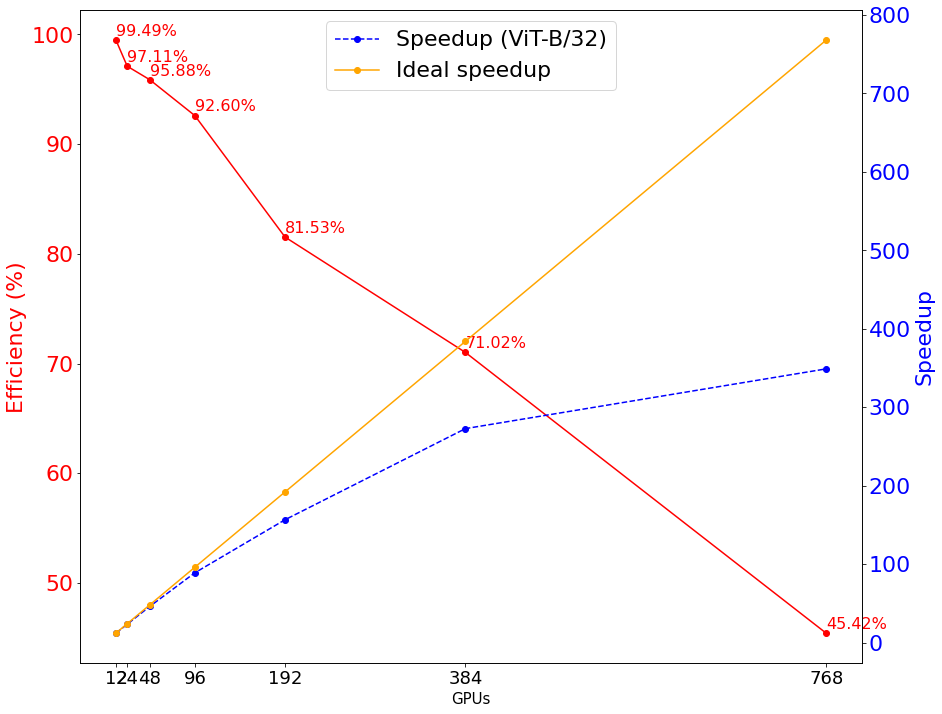

In [38]:
plot_scaling_and_efficiency(df, figsize=(14,12))
plt.savefig("scaling_efficiency_vitb32.pdf")

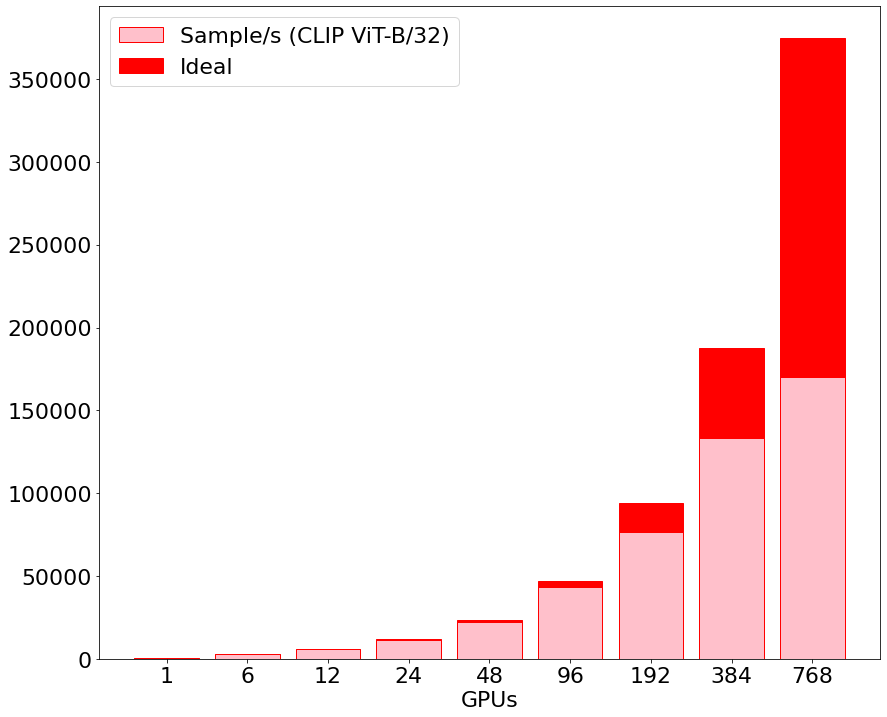

In [39]:
plot_images_per_sec(df, figsize=(14,12))
plt.savefig("images_per_sec_vitb32.pdf")